<a href="https://colab.research.google.com/github/JaimieOnigkeit/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Jaimie_Onigkeit_LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://raw.githubusercontent.com/JaimieOnigkeit/Unit-2-Build-Week/master/StudentsPerformance.csv')
df.rename(columns={'gender':'gender',
                   'race/ethnicity':'race_ethnicity',
                   'parental level of education':'parent_education_level',
                   'lunch':'lunch',
                   'test preparation course': 'test_prep_course',
                   'math score':'math_score',
                   'reading score':'reading_score',
                   'writing score':'writing_score'},
          inplace=True)
df.head()

,gender,race_ethnicity,parent_education_level,lunch,test_prep_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [62]:
df.dtypes

gender                    object
race_ethnicity            object
parent_education_level    object
lunch                     object
test_prep_course          object
math_score                 int64
reading_score              int64
writing_score              int64
dtype: object

In [63]:
df['gender'] = df.gender.astype('category')
df['race_ethnicity'] = df.race_ethnicity.astype('category')
df['parent_education_level'] = df.parent_education_level.astype('category')
df['lunch'] = df.lunch.astype('category')
df['test_prep_course'] = df.test_prep_course.astype('category')

df.head()

,gender,race_ethnicity,parent_education_level,lunch,test_prep_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [0]:
df['composite'] = df.math_score + df.reading_score + df.writing_score

target='composite'
#dropping the individual test results to prevent leakage
features= ['gender',	
           'race_ethnicity',	
           'parent_education_level',	
           'lunch',
           'test_prep_course']

train, test = train_test_split(df, test_size=.20, random_state=25)
train, val = train_test_split(train, test_size=.20, random_state=25)



In [0]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [66]:
pip install category_encoders

In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [68]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=5)
)


pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.00625


In [69]:
#Wow, that's terrible. .6%
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    DecisionTreeClassifier(max_depth=5)
)


pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.00625


In [70]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print ('Validation accuracy', accuracy_score(y_val, y_pred))

Validation accuracy 0.00625


In [71]:
#That's not any better.
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.0


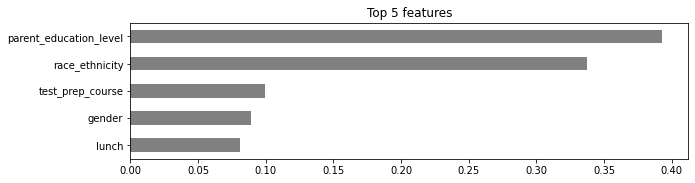

In [72]:
#Yeah, okay, this isn't working
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
#Okay, let's try it with just the top 2 features
features= ['race_ethnicity',	
           'parent_education_level']

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [74]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=5)
)


pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.0125


In [75]:
#That's about twice as good, I guess? 1.25%
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.00625


In [76]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print ('Validation accuracy', accuracy_score(y_val, y_pred))

Validation accuracy 0.0125


Okay, well, it looks like that;s about as good as it's going to get. I will rethink my targets for tomorrow.
